In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tfrecord_parser
import os
import cv2


model_name = '15827921154474332/cnn_var.ckpt-27456'
test_tfrecord = 'tfrecords/lfw_val.tfrecords'
width = 64
height = 64
channels = 3

In [2]:
sess = tf.Session()
saver = tf.train.import_meta_graph('checkpoints/{}.meta'.format(model_name))
saver.restore(sess, 'checkpoints/{}'.format(model_name))
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from checkpoints/15827921154474332/cnn_var.ckpt-27456


In [22]:
input_image = graph.get_tensor_by_name('input_image:0')
training_phase = graph.get_tensor_by_name('training_phase:0')
code = graph.get_tensor_by_name('code:0')
decoded = graph.get_tensor_by_name('decoded:0')

In [46]:
batch_size = 16

test_iterator, test_next_batch = tfrecord_parser.get_val_iterator(test_tfrecord, (width, height), batch_size)

sess.run(test_iterator.initializer)

codes_val = []
while True:
    try:
        x_np = sess.run(test_next_batch)
        feed_val = {input_image: x_np, training_phase: False}
        code_np = sess.run(code, feed_dict=feed_val)
        codes_val += code_np.tolist()
    except tf.errors.OutOfRangeError:
        break
codes_val = np.array(codes_val)

feed_val = {input_image: x_np, training_phase: False}
code_np, decoded_np = sess.run([code, decoded], feed_dict=feed_val)
print('X_batch length:', len(X_batch))
print('Batch shape', X_batch[0].shape)
print('Batch min and max', np.min(X_batch[0]), np.max(X_batch[0]))
print('Code shape', code_np.shape)
print('Code min and max', np.min(code_np), np.max(code_np))
print('Decoded shape', decoded_np.shape)
print('Decoded min and max', np.min(decoded_np), np.max(decoded_np))

X_batch length: 125
Batch shape (16, 64, 64, 3)
Batch min and max 0.0 1.0
Code shape (1, 16)
Code min and max -126.337 57.7242
Decoded shape (1, 64, 64, 3)
Decoded min and max 0.0 0.881312


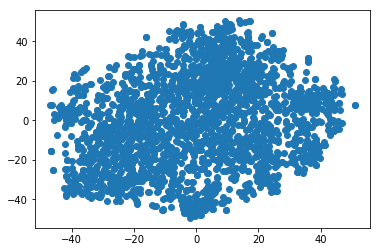

In [52]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(codes_val)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()


In [38]:
n_batches = len(X_batch)

codes_val = np.zeros((n_samples, code_np.shape[-1]))
for i in range(n_batches):
    i1 = i*batch_size
    i2 = (i+1)*batch_size
    feed_val = {input_image: X_batch[i], training_phase: False}
    code_np = sess.run(code, feed_dict=feed_val)
    codes_val[i1:i2,:] = code_np

print(code_np.shape)

(1, 16)


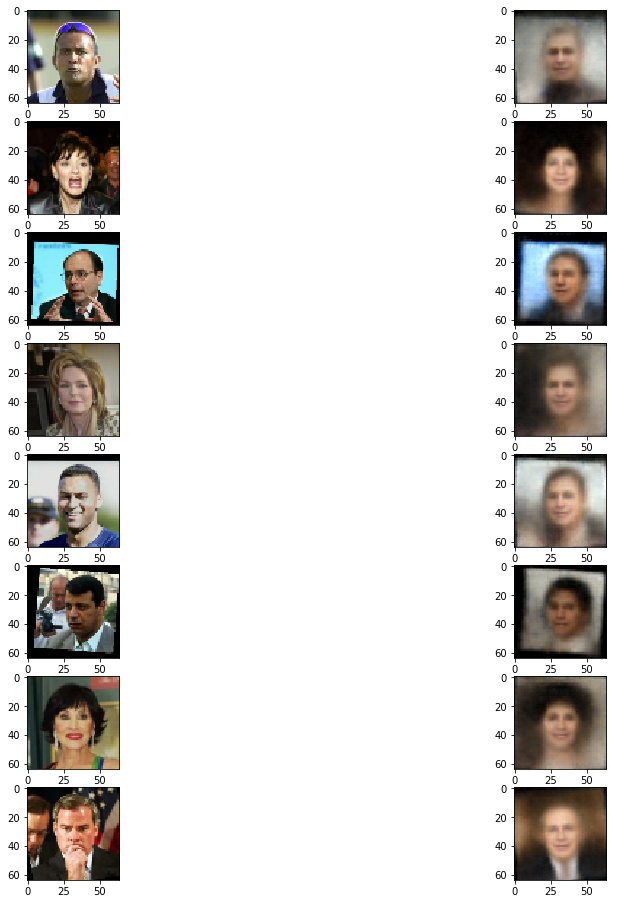

In [7]:
fig=plt.figure(figsize=(16,16))
k = 1
for i in range(8):
    fig.add_subplot(8, 2, k)
    plt.imshow((X_batch[0][i].reshape((height,width,channels))*255).astype(np.uint8))
    k += 1
    fig.add_subplot(8, 2, k)
    plt.imshow((decoded_np[i].reshape((height,width,channels))*255).clip(0,255).astype(np.uint8))
    k += 1
    
    

In [8]:
test_images_folder = 'test_images'
file_list = os.listdir(test_images_folder)

X_images_test = []
for f in file_list:
    image_path = os.path.join(test_images_folder, f)
    img = cv2.imread(image_path)
    if channels == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_images_test.append(cv2.resize(img, (width,height))/255.0)

X_images_test = np.array(X_images_test)
#X_images_test = X_images_test.reshape((-1, width*height*channels))

In [9]:
print('X_batch length:', len(X_images_test))
print('Batch shape', X_images_test[0].shape)
print('Batch min and max', np.min(X_images_test[0]), np.max(X_images_test[0]))

X_batch length: 14
Batch shape (64, 64, 3)
Batch min and max 0.0 0.976470588235


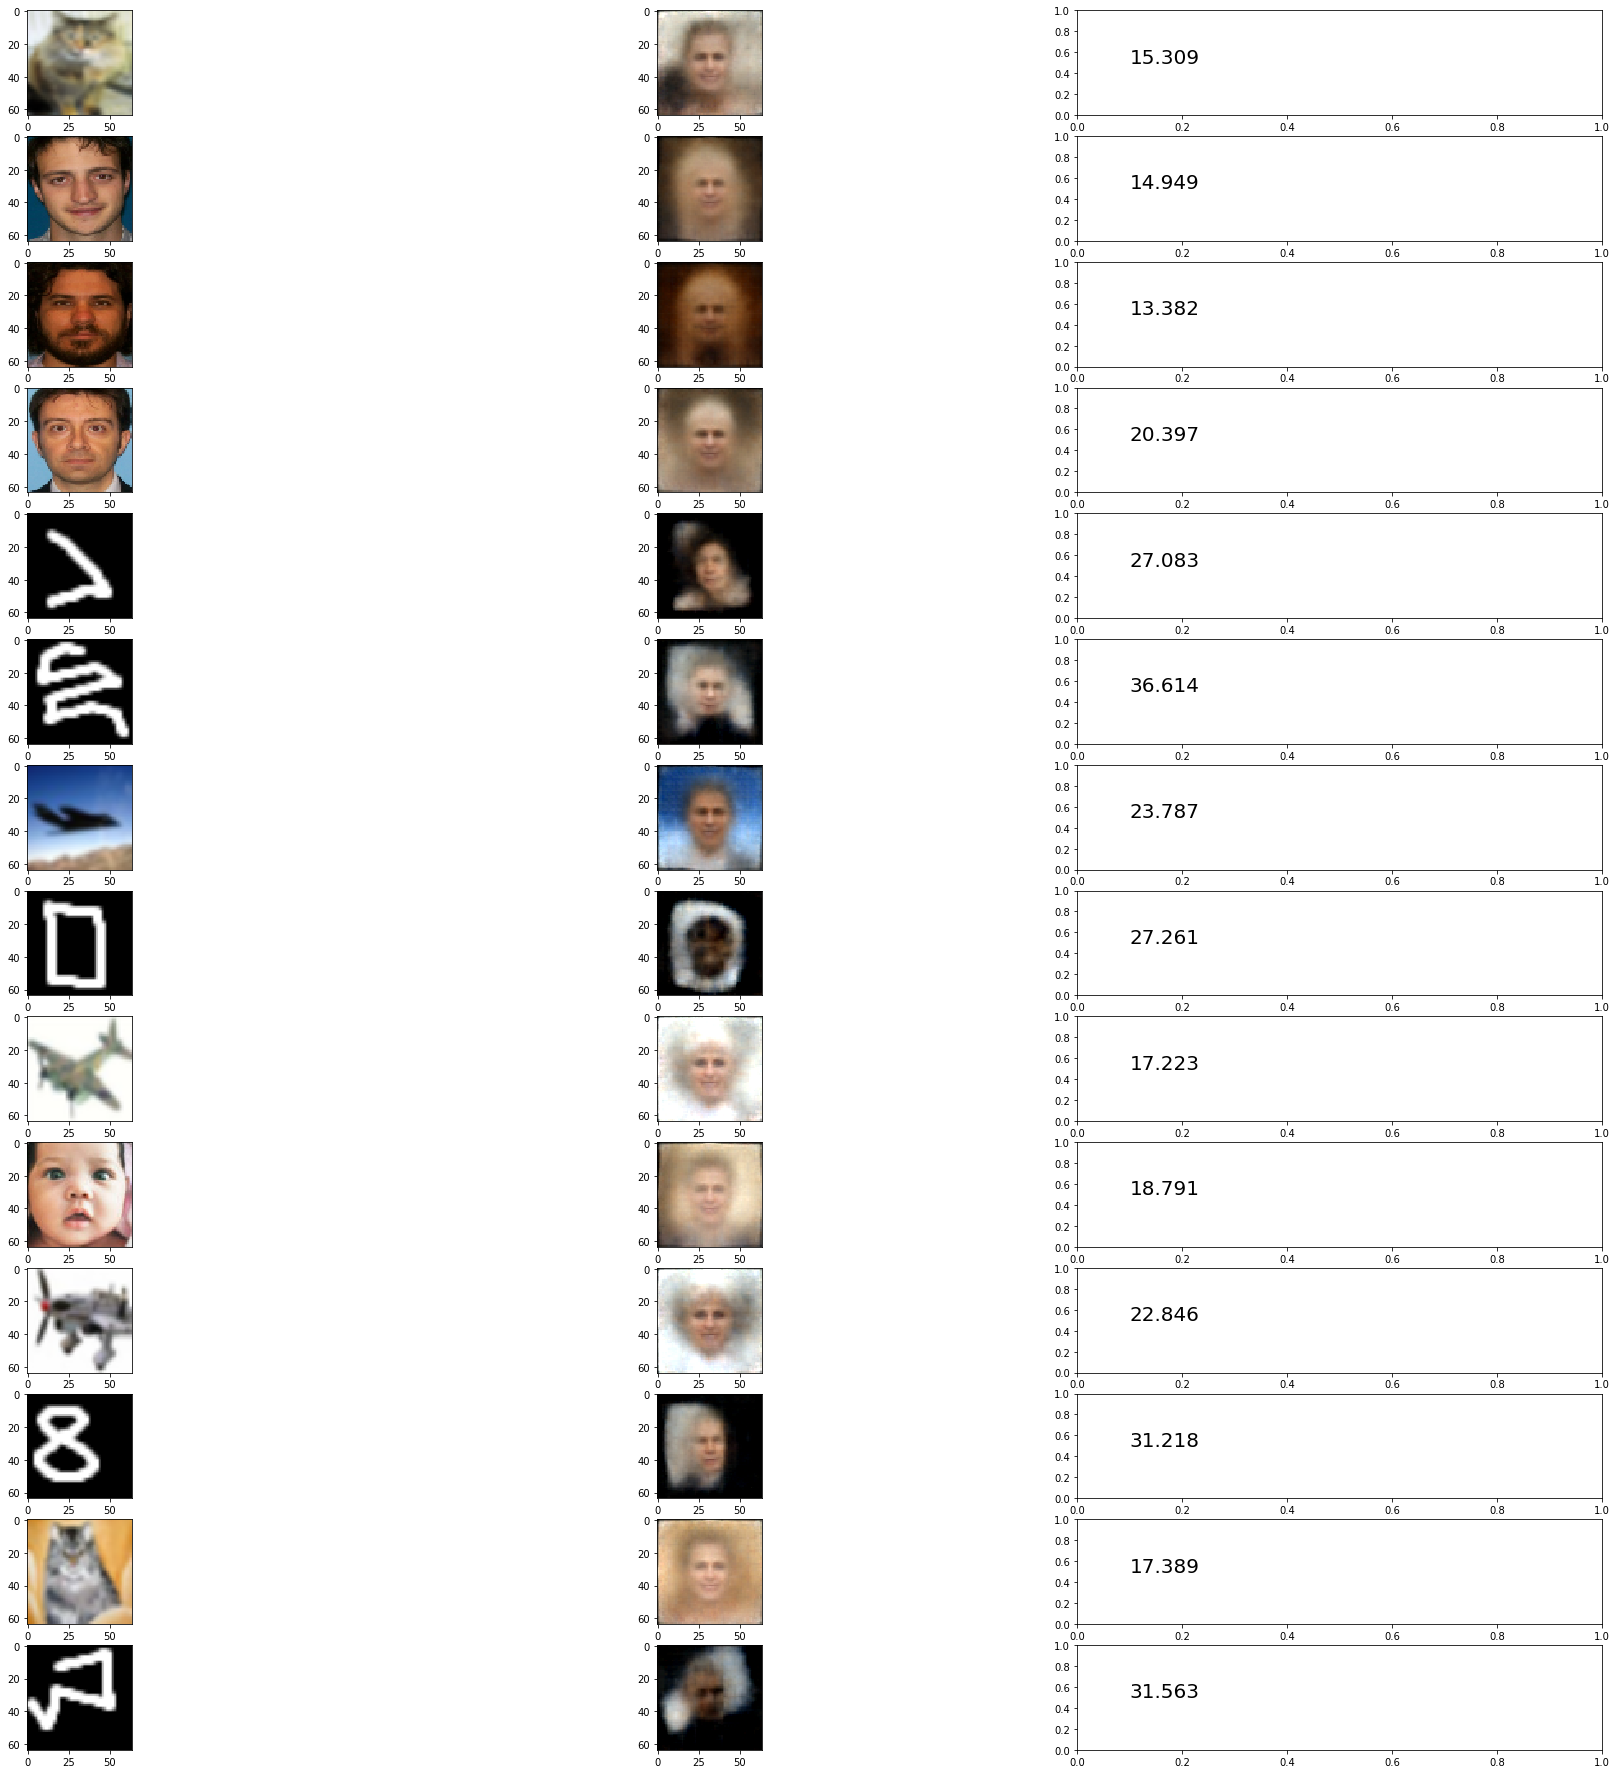

In [10]:
feed_val = {input_image: X_images_test, training_phase: False}
encoded_np, decoded_np = sess.run([encoded, decoded], feed_dict=feed_val)

n_images_test = len(X_images_test)
fig=plt.figure(figsize=(32,32))
k = 1
for i in range(n_images_test):
    fig.add_subplot(n_images_test, 3, k)
    plt.imshow((X_images_test[i].reshape((height,width,channels))*255).astype(np.uint8))
    k += 1
    fig.add_subplot(n_images_test, 3, k)
    plt.imshow((decoded_np[i].reshape((height,width,channels))*255).clip(0,255).astype(np.uint8))
    k += 1
    norm_str = '%.3f' % (np.linalg.norm(X_images_test[i]-decoded_np[i]))
    fig.add_subplot(n_images_test, 3, k)
    plt.text(0.1,0.5,norm_str,size=20)
    k += 1


In [11]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [18]:
def func(**param):
    plt.figure(0)
    n_param = len(param)
    code = np.zeros((1,n_param))
    i = 0
    for k in param.keys():
        code[0, i] = param[k]
        i += 1
    plt.imshow((sess.run(decoded, feed_dict={training_phase:False, 'Autoencoder/code_1:0': code})*255).astype(np.uint8)[0])
    plt.show()

    
n_latent = tf.get_default_graph().get_tensor_by_name('code:0').get_shape().as_list()[-1]
param = {}
for i in range(n_latent):
    param['p'+str(i)] =  widgets.IntSlider(min=-400,max=400)
    
interactive_plot = interactive(func, **param)
output = interactive_plot.children[-1]


interactive_plot
